# Viable traits

Compute the geographic habitat that is viable for each combination of traits within the [defined trait-space](trait-space-joint-pdf.ipynb).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from itertools import product

import dask
import data_collections as dc
import funnel
import matplotlib.pyplot as plt
import metabolic as mi
import numpy as np
import regrid_tools
import util
import xarray as xr

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Ecotype viability

A region is considered habitable for a given organism if $\Phi > 1$ (for resting metabolism) or $\Phi > \Phi_{crit}$ (for active metabolism).

The Metabolic Index is a nonlinear function; therefore, the order of operations can have an impact on results. Acknowledging this subtlety, we choose to compute $\Phi$ on a monthly climatology of $P_{\mathrm{O}_2}$ and temperature and asses regions as habitable on the basis of the annual-mean value of $\Phi$. Here is that computation. 

### Compute monthly climatology
First step: spin up a `dask` cluster.

In [3]:
try:
    cluster
    client
except:
    cluster, client = util.get_ClusterClient(memory='100GB')
    cluster.scale(32)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/asm/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/asm/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.52:42457,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/asm/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


Load data from the CESM-LE and compute a monthly, ensemble-mean climatology.

In [4]:
sub_spec = dict(
    name='drift-corrected',
    experiment=['20C'],
    member_id=dc.ocean_bgc_member_ids,
    variable=['pO2', 'TEMP'],
)

catalog = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)

exp_keys = [
    f'20C.ocn.pop.h.drift-corrected',
]
dsets = catalog.to_dataset_dict()
assert set(dsets.keys()) == set(exp_keys)

_, ds = dsets.popitem()

ds.z_t.attrs['long_name'] = 'Depth'

ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.name'


<xarray.Dataset>
Dimensions:     (member_id: 32, nlat: 384, nlon: 320, time: 1032, z_t: 40, d2: 2, z_t_150m: 15)
Coordinates:
  * member_id   (member_id) int64 2 9 10 11 12 13 14 ... 35 101 102 103 104 105
    KMT         (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TAREA       (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    TLAT        (member_id, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TLONG       (member_id, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    ULAT        (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG       (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    dz          (z_t) float32 1e+03 1e+03 1e+03 ... 9.844e+03 1.133e+04
  * time        (time) object 1920-01-17 00:29:59.999993 ... 2005-12-16 12:00:00
    time_bound  (time, d2) object 1920-01-02 00:59:59.999997 ... 2006-01-01 0...
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 8.788e+04 9.847e+04
  * z_t_150m    (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (member_id, time, z_t, nlat, nlon) float64 dask.array<chunksize=(1, 12, 10, 384, 320), meta=np.ndarray>
    pO2         (member_id, time, z_t, nlat, nlon) float64 dask.array<chunksize=(1, 12, 10, 384, 320), meta=np.ndarray>
Attributes: (12/14)
    nco_openmp_thread_number:  1
    cell_methods:              cell_methods = time: mean ==> the variable val...
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    tavg_sum:                  2592000.0
    intake_esm_varname:        TEMP\npO2
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    ...                        ...
    source:                    CCSM POP2, the CCSM Ocean Component
    calendar:                  All years have exactly  365 days.
    tavg_sum_qflux:            2592000.0
    nsteps_total:              750
    history:                   none\nTue Sep 10 06:07:07 2013: /glade/apps/op...
    intake_esm_dataset_key:    20C.ocn.pop.h.drift-corrected

Choose a reference period corresponding to near-present and WOA2018 oxygen data compilation.

In [5]:
ds_clm = (
    ds.sel(time=slice("1960", "2017"))
    .mean("member_id")
    .groupby("time.month")
    .mean("time")
    .rename({"month": "time"})
    .compute()
)
ds_clm

<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 320, time: 12, z_t: 40, z_t_150m: 15)
Coordinates:
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    ULAT      (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG     (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
    dz        (z_t) float32 1e+03 1e+03 1e+03 ... 8.521e+03 9.844e+03 1.133e+04
  * z_t       (z_t) float32 500.0 1.5e+03 2.5e+03 ... 8.788e+04 9.847e+04
  * z_t_150m  (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
  * time      (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP      (time, z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan
    pO2       (time, z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan

Load the WOA2018 data to compute viability on obs as well.

In [6]:
cat = util.curator_local_assets().open_catalog()
ds_woa = cat['woa2018'].to_dask()
ds_woa

<xarray.Dataset>
Dimensions:     (time: 12, depth: 47, lat: 180, lon: 360, nbounds: 2)
Coordinates:
  * depth       (depth) float32 0.0 5.0 10.0 15.0 ... 850.0 900.0 950.0 1e+03
    depth_bnds  (depth, nbounds) float32 dask.array<chunksize=(47, 2), meta=np.ndarray>
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: time, nbounds
Data variables:
    O2          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 47, 180, 360), meta=np.ndarray>
    SALT        (time, depth, lat, lon) float32 dask.array<chunksize=(1, 47, 180, 360), meta=np.ndarray>
    TEMP        (time, depth, lat, lon) float32 dask.array<chunksize=(1, 47, 180, 360), meta=np.ndarray>
    area        (lat, lon) float64 dask.array<chunksize=(90, 360), meta=np.ndarray>
    dz          (depth) float32 dask.array<chunksize=(47,), meta=np.ndarray>
    pO2         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 47, 180, 360), meta=np.ndarray>
    volume      (depth, lat, lon) float64 dask.array<chunksize=(47, 180, 360), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    cdm_data_type:                   Grid
    comment:                         global climatology as part of the World ...
    contributor_name:                Ocean Climate Laboratory
    contributor_role:                Calculation of climatologies
    creator_email:                   NCEI.info@noaa.gov
    ...                              ...
    summary:                         Climatological mean dissolved oxygen for...
    time_coverage_duration:          P!!Y
    time_coverage_end:               2017-01-31
    time_coverage_resolution:        P01M
    time_coverage_start:             1900-01-01
    title:                           World Ocean Atlas 2018 : mole_concentrat...

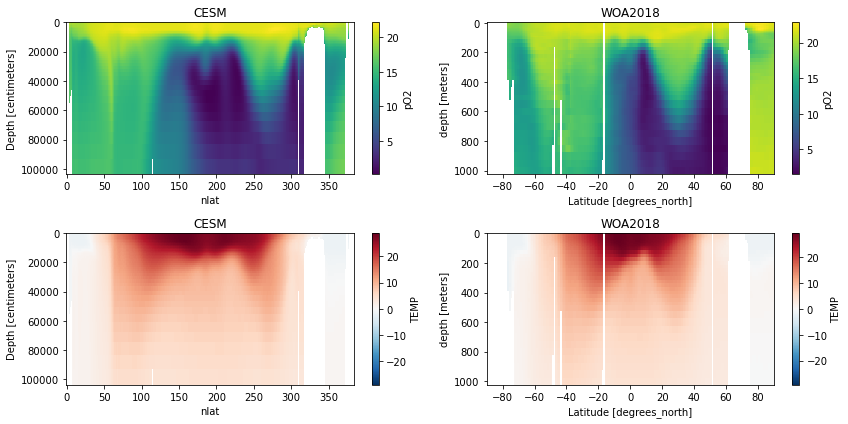

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
ds_clm.pO2.isel(nlon=200).mean('time').plot(yincrease=False, ax=axs[0, 0])
axs[0, 0].set_title('CESM')

ds_woa.pO2.sel(lon=179.5).mean('time').plot(yincrease=False, ax=axs[0, 1])
axs[0, 1].set_title('WOA2018')

ds_clm.TEMP.isel(nlon=200).mean('time').plot(yincrease=False, ax=axs[1, 0])
axs[1, 0].set_title('CESM')

ds_woa.TEMP.sel(lon=179.5).mean('time').plot(yincrease=False, ax=axs[1, 1])
axs[1, 1].set_title('WOA2018')
plt.tight_layout();

In [8]:
ds_1x1 = regrid_tools.generate_latlon_grid(nx=360, ny=180, lon0=-180.0)[["area"]]
ds_1x1['z_t'] = ds.z_t
ds_1x1['dz'] = ds.dz

src_grid = regrid_tools.grid("POP_gx1v6")
dst_grid = regrid_tools.grid("latlon", nx=360, ny=180, lon0=-180.0)
regrid_obj = regrid_tools.regridder(src_grid, dst_grid, method="bilinear", clobber=False)
regrid_obj

exists: /glade/scratch/mclong/tmp/regridding/POP_gx1v6.nc
exists: /glade/scratch/mclong/tmp/regridding/latlon_1.0x1.0_lon0=-180.0.nc
source grid dims: (384, 320)
destination grid dims: (180, 360)


regridder POP_gx1v6.nc --> latlon_1.0x1.0_lon0=-180.0.nc

In [9]:
%%time
ds_1x1 = xr.merge(
    (
        ds_1x1,
        regrid_obj(ds_clm[["TEMP", "pO2"]], renormalize=True, apply_mask=True).rename(
            {"nlat": "lat", "nlon": "lon"}
        ),
    )
)
ds_1x1['area'] = ds_woa.area
ds_1x1

CPU times: user 1.4 s, sys: 994 ms, total: 2.4 s
Wall time: 2.44 s


<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, z_t: 40, time: 12)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    dz       (z_t) float32 1e+03 1e+03 1e+03 ... 8.521e+03 9.844e+03 1.133e+04
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 8.788e+04 9.847e+04
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    area     (lat, lon) float64 dask.array<chunksize=(90, 360), meta=np.ndarray>
    TEMP     (time, z_t, lat, lon) float64 nan nan nan ... 0.6726 0.6725 0.6724
    pO2      (time, z_t, lat, lon) float64 nan nan nan nan ... 18.15 18.15 18.15

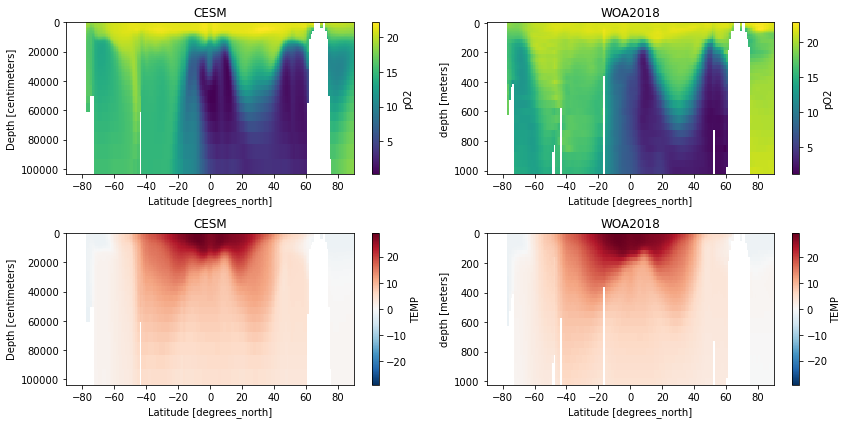

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
ds_1x1.pO2.isel(lon=0).mean('time').plot(yincrease=False, ax=axs[0, 0])
axs[0, 0].set_title('CESM')

ds_woa.pO2.isel(lon=0).mean('time').plot(yincrease=False, ax=axs[0, 1])
axs[0, 1].set_title('WOA2018')

ds_1x1.TEMP.isel(lon=0).mean('time').plot(yincrease=False, ax=axs[1, 0])
axs[1, 0].set_title('CESM')

ds_woa.TEMP.isel(lon=0).mean('time').plot(yincrease=False, ax=axs[1, 1])
axs[1, 1].set_title('WOA2018')
plt.tight_layout();

### Compute viability 

First load trait space PDF.

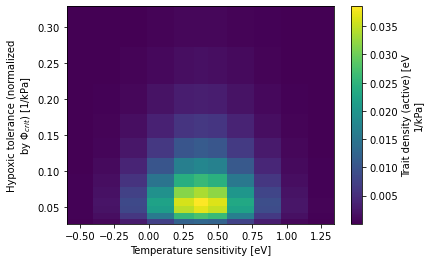

In [11]:
curator = util.curator_local_assets()
cat = curator.open_catalog()
ds_trait_space = cat['trait-space'].to_dask().load()

ds_trait_space.trait_spc_active.plot();

In [12]:
ds_trait_space.trait_spc_active

<xarray.DataArray 'trait_spc_active' (Ac: 12, Eo: 11)>
array([[1.00358230e-04, 6.72698399e-04, 2.81408643e-03, 7.33609608e-03,
        1.19297474e-02, 1.27449962e-02, 1.20953656e-02, 7.64600251e-03,
        3.01496564e-03, 7.40878515e-04, 1.13620084e-04],
       [2.15385464e-04, 1.44372273e-03, 6.03949784e-03, 1.57444832e-02,
        2.56032234e-02, 2.73528831e-02, 2.59586678e-02, 1.64095940e-02,
        6.47061807e-03, 1.59004860e-03, 2.43847612e-04],
       [2.90987855e-04, 1.95048344e-03, 8.15942028e-03, 2.12709498e-02,
        3.45902036e-02, 3.69540110e-02, 3.50704125e-02, 2.21695209e-02,
        8.74186790e-03, 2.14817112e-03, 3.29440494e-04],
       [3.03348682e-04, 2.03333771e-03, 8.50602299e-03, 2.21745151e-02,
        3.60595553e-02, 3.85237745e-02, 3.65601629e-02, 2.31112565e-02,
        9.11321231e-03, 2.23942293e-03, 3.43434744e-04],
       [2.65211673e-04, 1.77770641e-03, 7.43664545e-03, 1.93867342e-02,
        3.15261466e-02, 3.36805640e-02, 3.19638178e-02, 2.02057084e-02,
        7.96749890e-03, 1.95788259e-03, 3.00258114e-04],
       [2.02910265e-04, 1.36010182e-03, 5.68968808e-03, 1.48325574e-02,
        2.41202760e-02, 2.57685949e-02, 2.44551330e-02, 1.54591447e-02,
        6.09583768e-03, 1.49795245e-03, 2.29723876e-04],
       [1.38808801e-04, 9.30431502e-04, 3.89225641e-03, 1.01467982e-02,
        1.65004298e-02, 1.76280276e-02, 1.67295020e-02, 1.05754401e-02,
        4.17009913e-03, 1.02473368e-03, 1.57151713e-04],
       [8.60027226e-05, 5.76473839e-04, 2.41155205e-03, 6.28672147e-03,
        1.02232847e-02, 1.09219182e-02, 1.03652125e-02, 6.55229806e-03,
        2.58369697e-03, 6.34901290e-04, 9.73675666e-05],
       [4.88294430e-05, 3.27302387e-04, 1.36919786e-03, 3.56938825e-03,
        5.80443598e-03, 6.20109650e-03, 5.88501779e-03, 3.72017367e-03,
        1.46693593e-03, 3.60475522e-04, 5.52820178e-05],
       [2.54539295e-05, 1.70616976e-04, 7.13738753e-04, 1.86065930e-03,
        3.02575035e-03, 3.23252251e-03, 3.06775624e-03, 1.93926109e-03,
        7.64687892e-04, 1.87909548e-04, 2.88175433e-05],
       [1.22509648e-05, 8.21178736e-05, 3.43522140e-04, 8.95534480e-04,
        1.45629228e-03, 1.55581163e-03, 1.47650969e-03, 9.33365485e-04,
        3.68043938e-04, 9.04407805e-05, 1.38698706e-05],
       [5.43994403e-06, 3.64637924e-05, 1.52538289e-04, 3.97655003e-04,
        6.46655070e-04, 6.90845848e-04, 6.55632452e-04, 4.14453562e-04,
        1.63427000e-04, 4.01595133e-05, 6.15880634e-06]])
Coordinates:
  * Ac       (Ac) float64 0.03 0.037 0.0456 0.0562 ... 0.1601 0.1974 0.2433 0.3
  * Eo       (Eo) float64 -0.5 -0.3056 -0.1111 0.0833 ... 0.8611 1.056 1.25
Attributes:
    N_traits:            132
    long_name:           Trait density (active)
    metabolic_baseline:  active
    units:               eV 1/kPa

Loop over trait space and construct a mask for where each trait combination is viable. Viability is defined on the basis of being able to sustain active metabolism. However, to facilitate agregation of resting metabolic trait frequencies, here we produce "viability masks" for both active (`viability_active`) and resting (`viability_resting`) combinations. The `viability_resting` field is the exact same data, but the coordinates are changed to resting traits.  Note that this requires `Ao` and `Ac` coordinates to be of the same length, which is enforced in the [construction of the trait-space](construct-trait-space).

In [13]:
%%time


dpm = xr.DataArray(
    [31.0, 28.0, 31.0, 30.0, 31.0, 30.0, 31.0, 31.0, 30.0, 31.0, 30.0, 31.0],
    dims=("time"),
)


phi_upper_bound = 2


@dask.delayed
def Phi_mean(ds, Ac, Eo):
    """
    Compute the time-mean Metabolic Index from a dataset
    with pO2 and TEMP fields and provided paramters.
    """
    return mi.Phi(ds.pO2, ds.TEMP, Ac, Eo, dEodT=mi.dEodT_bar).weighted(dpm).mean("time")


dsets = {}
for key, ds_in in {"cesm-1x1": ds_1x1, "woa2018": ds_woa}.items():

    ds_future = client.scatter(ds_in)

    dso = xr.Dataset()

    for v in ["trait_spc_active", "trait_spc_resting"]:
        trait_space = ds_trait_space[v]
        hypoxic_tol, temp_sens = trait_space.dims
        metabolic_baseline = trait_space.attrs['metabolic_baseline']

        ATmax_varname = f"ATmax_{metabolic_baseline}"
        Phi_varname = f"Phi_{metabolic_baseline}"

        ni = len(trait_space[hypoxic_tol])
        nj = len(trait_space[temp_sens])

        # loop over trait space and lat bands, sum trait frequency
        da_list_outer = []
        for i, A_parm in enumerate(trait_space[hypoxic_tol].values):
            da_list_inner = []
            for j, Eo in enumerate(trait_space[temp_sens].values):
                da_list_inner.append(Phi_mean(ds_future, A_parm, Eo))
            da_list_outer.append(da_list_inner)

        # compute delayed objects
        computed_list = dask.compute(*[obj for inner_list in da_list_outer for obj in inner_list])

        # concatenate over trait space
        da_list_outer = []
        for i in range(ni):
            da_list_outer.append(
                xr.concat(computed_list[i * nj : i * nj + nj], dim=trait_space[temp_sens])
            )

        # assignments
        dso[Phi_varname] = xr.concat(da_list_outer, dim=trait_space[hypoxic_tol])
        dso[v] = ds_trait_space[v]
        dso[ATmax_varname] = ds_trait_space[ATmax_varname]

    # compute viability
    via_mask = xr.where((1 < dso.Phi_active) & (dso.Phi_active <= phi_upper_bound), 1.0, 0.0)
    via_mask.attrs['long_name'] = r'viability based on $\Phi$ criterion'
    dso['viability_active'] = via_mask

    # viability for the "resting" trait space is the same,
    # but the coordinates are different, so change those here
    via_mask_resting = via_mask.reset_index('Ac', drop=True).rename({'Ac': 'Ao'})
    via_mask_resting = via_mask_resting.assign_coords(Ao=ds_trait_space.Ao)
    via_mask_resting = via_mask_resting.set_index(Ao='Ao')
    dso['viability_resting'] = via_mask_resting

    dso['dz'] = ds_in.dz
    dso['area'] = ds_in.area
    dsets[key] = dso

dsets

CPU times: user 8.25 s, sys: 11 s, total: 19.2 s
Wall time: 44.6 s


{'cesm-1x1': <xarray.Dataset>
 Dimensions:            (Ac: 12, Eo: 11, lat: 180, lon: 360, z_t: 40, Ao: 12)
 Coordinates:
   * Ac                 (Ac) float64 0.03 0.037 0.0456 ... 0.1974 0.2433 0.3
   * Eo                 (Eo) float64 -0.5 -0.3056 -0.1111 ... 0.8611 1.056 1.25
   * lat                (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
   * lon                (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
     dz                 (z_t) float32 1e+03 1e+03 1e+03 ... 9.844e+03 1.133e+04
   * z_t                (z_t) float32 500.0 1.5e+03 ... 8.788e+04 9.847e+04
   * Ao                 (Ao) float64 0.06811 0.08867 0.1147 ... 0.784 0.9872
 Data variables:
     Phi_active         (Ac, Eo, z_t, lat, lon) float64 nan nan ... 39.19 39.19
     trait_spc_active   (Ac, Eo) float64 0.0001004 0.0006727 ... 6.159e-06
     ATmax_active       (Ac, Eo) float64 nan nan nan nan ... 27.2 25.63 24.37
     Phi_resting        (Ao, Eo, z_t, lat, lon) float64 nan nan ... 129.0 12

## Visualize viability fields

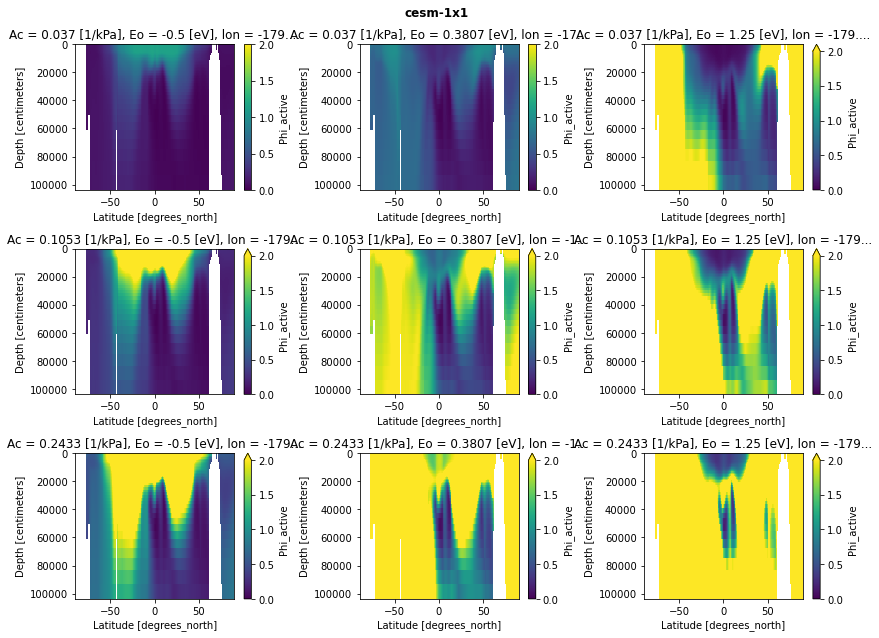

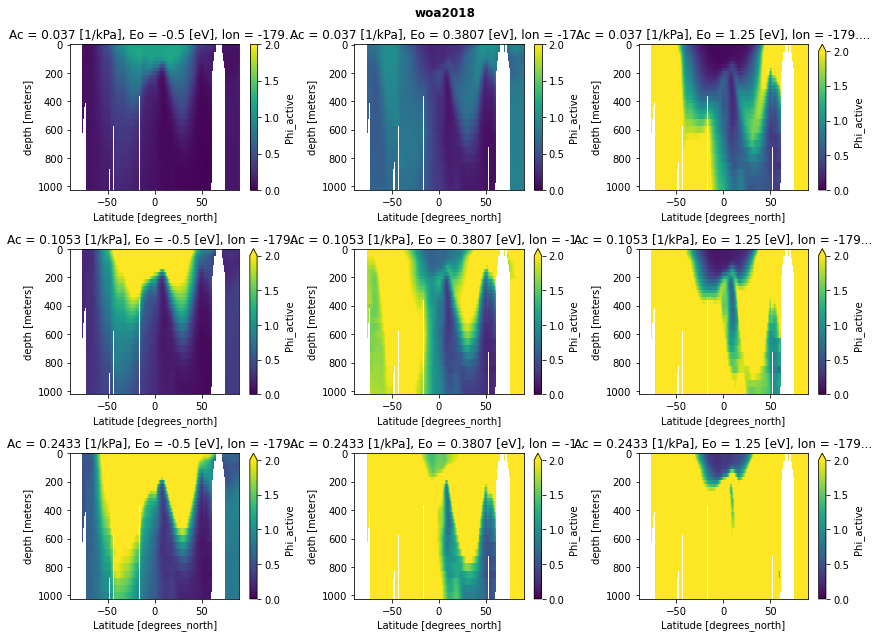

In [14]:
for key, dso in dsets.items():

    Eo = dso.Eo.sel(Eo=np.percentile(dso.Eo, [5, 50, 95], interpolation='nearest'))
    Ac = dso.Ac.sel(Ac=np.percentile(dso.Ac, [5, 50, 95], interpolation='nearest'))

    fig, axs = plt.subplots(len(Ac), len(Eo), figsize=(12, 9))
    for i, j in product(range(len(Ac)), range(len(Eo))):
        dso.Phi_active.sel(Eo=Eo[j], Ac=Ac[i]).isel(lon=0).plot(
            yincrease=False,
            ax=axs[i, j],
            vmin=0,
            vmax=2,
        )
    plt.suptitle(key, fontweight='bold')
    plt.tight_layout();

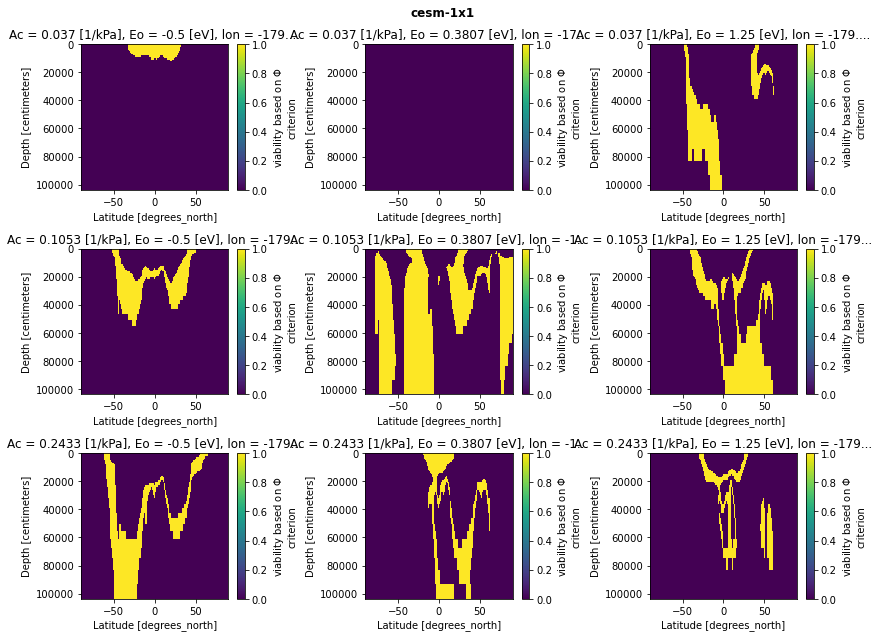

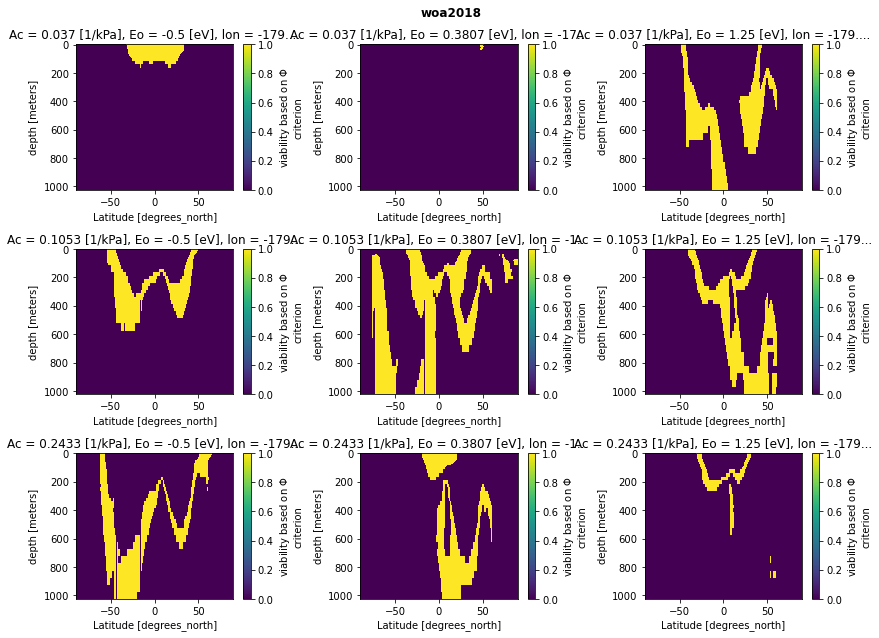

In [15]:
for key, dso in dsets.items():
    Eo = dso.Eo.sel(Eo=np.percentile(dso.Eo, [5, 50, 95], interpolation='nearest'))
    Ac = dso.Ac.sel(Ac=np.percentile(dso.Ac, [5, 50, 95], interpolation='nearest'))

    fig, axs = plt.subplots(len(Ac), len(Eo), figsize=(12, 9))
    for i, j in product(range(len(Ac)), range(len(Eo))):
        dso.viability_active.sel(Eo=Eo[j], Ac=Ac[i]).isel(lon=0).plot(
            yincrease=False,
            ax=axs[i, j],
            vmin=0,
            vmax=1,
        )
    plt.suptitle(key, fontweight='bold')
    plt.tight_layout();

## Write a cache file

In [16]:
for ds in dsets.values():
    chunk_dict = {k: ds.sizes[k] for k in ds.dims}
    chunk_dict.update({'lat': 1})
    ds = ds.chunk(chunk_dict)
    ds = ds.unify_chunks()
    for v in ds.data_vars:
        for offending_key in ['chunks', 'preferred_chunks']:
            if offending_key in ds[v].encoding:
                del ds[v].encoding[offending_key]

In [17]:
this_notebook = 'compute-viable-traits.ipynb'

curator = util.curator_local_assets()

for ds_key, dso in dsets.items():
    key = f'viable-traits-mask-{ds_key}'

    cache_file = f'{dc.cache_dir}/{key}.zarr'
    os.makedirs(os.path.dirname(cache_file), exist_ok=True)

    dso.to_zarr(cache_file, mode='w', consolidated=True)

    curator.add_source(
        key=key,
        urlpath=cache_file,
        description=f"""
        Viable traits mask computed from {ds_key} by {this_notebook}
        Viability criteria: 
          - via_Phi: 1 < mean(Phi) < {phi_upper_bound}
          - via_ATmax: mean(T) < ATmax
        """,
        driver='zarr',
        overwrite=True,
    )

overwriting "viable-traits-mask-cesm-1x1" key in "sources"


overwriting "viable-traits-mask-woa2018" key in "sources"


In [18]:
if True:
    cluster.close()
    client.close()